Using device: cpu


Classes: ['NORMAL', 'PNEUMONIA']


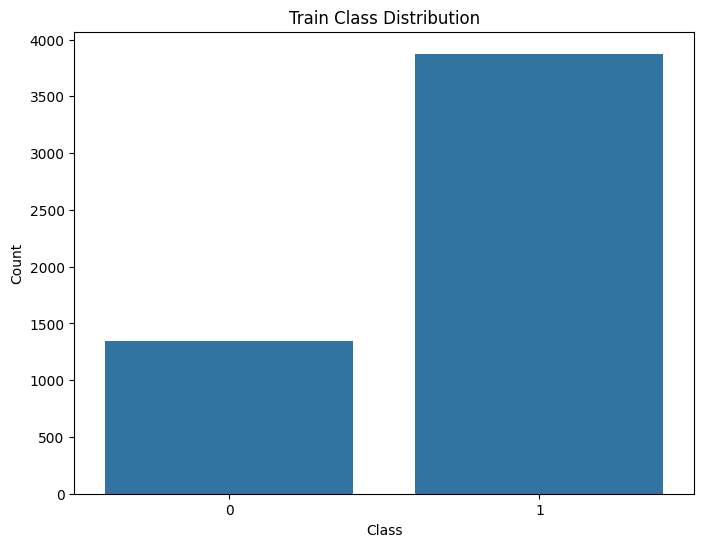

Epoch 1/15 - Training:   0%|          | 0/163 [00:00<?, ?it/s]C:\Users\maiab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/15 - Validation: 100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


Epoch 1: Train Loss=0.5306, Val Loss=0.5687, Val Acc=68.75%


Epoch 2/15 - Validation: 100%|██████████| 1/1 [00:12<00:00, 12.22s/it]


Epoch 2: Train Loss=0.3990, Val Loss=0.4284, Val Acc=75.00%


Epoch 3/15 - Validation: 100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


Epoch 3: Train Loss=0.3430, Val Loss=0.3923, Val Acc=75.00%


Epoch 4/15 - Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Epoch 4: Train Loss=0.3009, Val Loss=0.3589, Val Acc=75.00%


Epoch 5/15 - Validation: 100%|██████████| 1/1 [00:16<00:00, 16.85s/it]


Epoch 5: Train Loss=0.2733, Val Loss=0.3248, Val Acc=81.25%


Epoch 6/15 - Validation: 100%|██████████| 1/1 [00:19<00:00, 19.16s/it]


Epoch 6: Train Loss=0.2698, Val Loss=0.2960, Val Acc=81.25%


Epoch 7/15 - Validation: 100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Epoch 7: Train Loss=0.2521, Val Loss=0.2928, Val Acc=81.25%


Epoch 8/15 - Validation: 100%|██████████| 1/1 [00:19<00:00, 19.36s/it]


Epoch 8: Train Loss=0.2476, Val Loss=0.3056, Val Acc=81.25%


Epoch 9/15 - Validation: 100%|██████████| 1/1 [00:19<00:00, 19.63s/it]


Epoch 9: Train Loss=0.2297, Val Loss=0.2976, Val Acc=81.25%


Epoch 10/15 - Validation: 100%|██████████| 1/1 [00:20<00:00, 20.06s/it]


Epoch 10: Train Loss=0.2310, Val Loss=0.2954, Val Acc=87.50%


Epoch 11/15 - Validation: 100%|██████████| 1/1 [00:16<00:00, 16.70s/it]


Epoch 11: Train Loss=0.2297, Val Loss=0.2752, Val Acc=81.25%


Epoch 12/15 - Validation: 100%|██████████| 1/1 [00:16<00:00, 16.94s/it]


Epoch 12: Train Loss=0.2279, Val Loss=0.2932, Val Acc=87.50%


Epoch 13/15 - Validation: 100%|██████████| 1/1 [00:16<00:00, 16.83s/it]


Epoch 13: Train Loss=0.2323, Val Loss=0.3030, Val Acc=87.50%


Epoch 14/15 - Validation: 100%|██████████| 1/1 [00:20<00:00, 20.15s/it]


Epoch 14: Train Loss=0.2233, Val Loss=0.2779, Val Acc=81.25%


Epoch 15/15 - Validation: 100%|██████████| 1/1 [00:17<00:00, 17.08s/it]


Epoch 15: Train Loss=0.2221, Val Loss=0.2782, Val Acc=81.25%


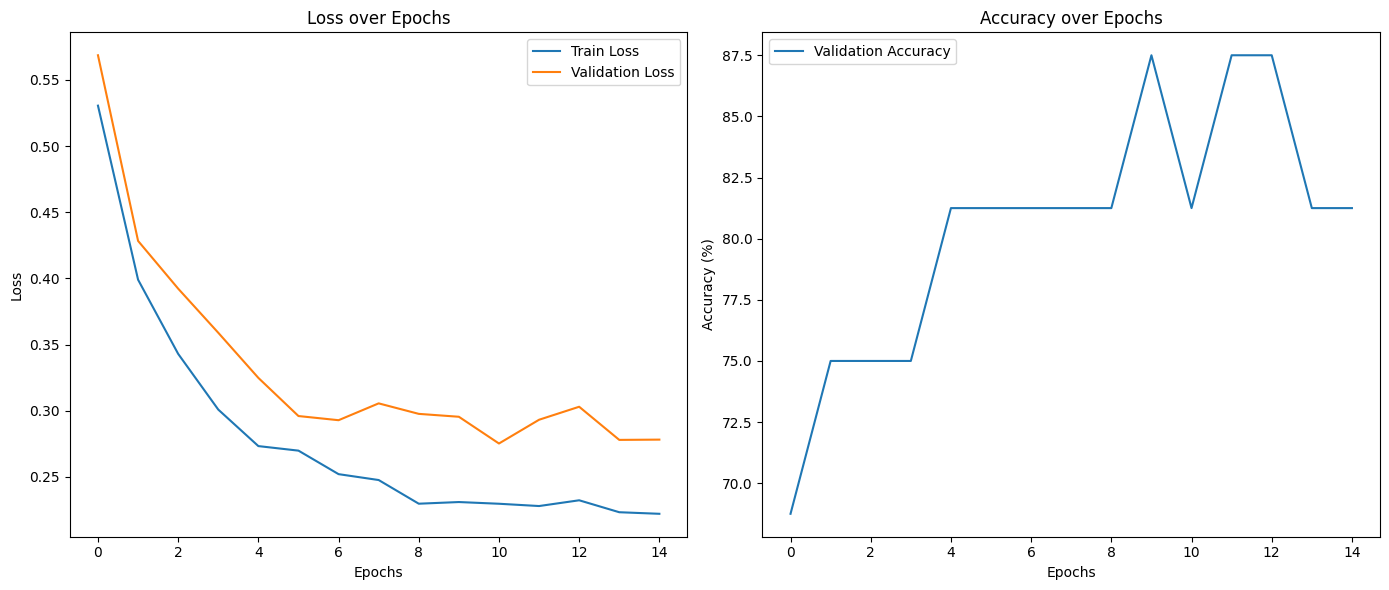

Evaluating: 100%|██████████| 20/20 [00:54<00:00,  2.75s/it]


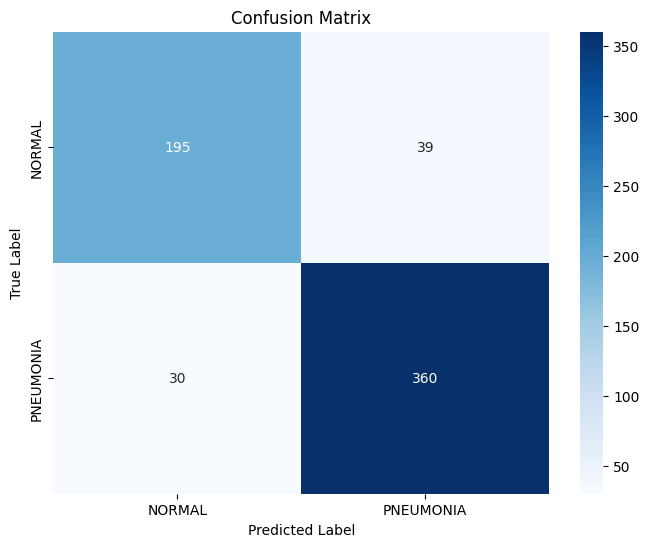

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▃▃▃▆▆▆▆▆█▆██▆▆
Validation Loss,█▅▄▃▂▁▁▂▂▁▁▁▂▁▁
Epoch,15
Train Loss,0.22208
Validation Accuracy,81.25
Validation Loss,0.27815


In [2]:
import os
import random
import json
import time

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image

import optuna
from optuna.trial import Trial

import wandb

# Setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Output Directory
output_dir = "results_resnet"
os.makedirs(output_dir, exist_ok=True)

# Initialize Weights & Biases
wandb.init(project="Pneumonia-Detection-ResNet", config={
    "architecture": "ResNet18",
    "dataset": "Chest_Xray",
    "framework": "PyTorch"
})

# Data Preparation
def get_transforms(resize=224, rotation=10, translate=0.05):
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((resize, resize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(rotation),
        transforms.RandomAffine(degrees=0, translate=(translate, translate)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    eval_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return train_transform, eval_transform

def load_data(train_transform, eval_transform, batch_size=32):
    data_path = "chest_Xray"
    train_dataset = datasets.ImageFolder(os.path.join(data_path, "train"), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_path, "val"), transform=eval_transform)
    test_dataset = datasets.ImageFolder(os.path.join(data_path, "test"), transform=eval_transform)

    class_names = train_dataset.classes
    print(f"Classes: {class_names}")

    with open(os.path.join(output_dir, "class_mapping.json"), 'w') as f:
        json.dump(train_dataset.class_to_idx, f)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, class_names

# Visualization
def plot_class_distribution(dataset, title="Class Distribution"):
    labels = [label for _, label in dataset]
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.savefig(os.path.join(output_dir, f"{title.replace(' ', '_').lower()}.png"))
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"))
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.show()

# Model
def create_model(model_name, num_classes, dropout_rate=0.3, freeze_layers=True):
    model = getattr(models, model_name)(weights='IMAGENET1K_V1')

    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )

    return model.to(device)

# Training
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_model_path = os.path.join(output_dir, "best_model.pth")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        if scheduler:
            scheduler.step(avg_val_loss)

        # Log to wandb
        wandb.log({
            "Train Loss": avg_train_loss,
            "Validation Loss": avg_val_loss,
            "Validation Accuracy": val_accuracy,
            "Epoch": epoch + 1
        })

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model, history, val_accuracy

# Evaluation
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose()
    cm = confusion_matrix(y_true, y_pred)
    return report_df, cm

# Save Results
def save_results_to_parquet(history, report_df, cm, class_names):
    history_df = pd.DataFrame(history)
    pq.write_table(pa.Table.from_pandas(history_df), os.path.join(output_dir, "training_history.parquet"))
    pq.write_table(pa.Table.from_pandas(report_df), os.path.join(output_dir, "classification_report.parquet"))
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    pq.write_table(pa.Table.from_pandas(cm_df), os.path.join(output_dir, "confusion_matrix.parquet"))

# Hyperparameter Optimization
def objective(trial: Trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.6)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    freeze_layers = trial.suggest_categorical("freeze_layers", [True, False])

    train_transform, eval_transform = get_transforms()
    train_loader, val_loader, _, class_names = load_data(train_transform, eval_transform, batch_size=batch_size)

    model = create_model("resnet18", num_classes=len(class_names), dropout_rate=dropout_rate, freeze_layers=freeze_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    _, _, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, patience=3)

    return val_acc

# Main
if __name__ == "__main__":
    train_transform, eval_transform = get_transforms()
    train_loader, val_loader, test_loader, class_names = load_data(train_transform, eval_transform)

    # EDA
    plot_class_distribution(train_loader.dataset, "Train Class Distribution")
    
    model = create_model("resnet18", num_classes=len(class_names))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    model, history, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15)

    plot_training_history(history)

    report_df, cm = evaluate_model(model, test_loader, class_names)
    plot_confusion_matrix(cm, class_names)

    save_results_to_parquet(history, report_df, cm, class_names)

    # Finish wandb
    wandb.finish()